In [1]:
# Notebook: Multi-label via pseudo-labeling
# Uso: cole este arquivo em uma célula de um Jupyter Notebook e execute por partes
# Objetivo:
# 1) Treinar modelo single-label em Imagens_um_Alimento
# 2) Prever e gerar pseudo-labels para Imagens_Varios_Alimentos
# 3) Treinar modelo multi-label usando ambos (com pseudo-labels)
# 4) Avaliar métricas multi-label e salvar resultados

# --------------------------------------------------
# Célula 1 - imports e configurações
# --------------------------------------------------
import os
import random
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
import torchvision
from torchvision import transforms, models, datasets

from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             multilabel_confusion_matrix, classification_report,
                             hamming_loss)

# Configurações principais - ajuste conforme necessário
SEED = 42
DATA_ROOT = Path('.')  # diretório atual do notebook
SINGLE_DIR = DATA_ROOT / 'Imagens_um_Alimento'
VARIOS_DIR = DATA_ROOT / 'Imagens_Varios_Alimentos'
OUTPUT_DIR = Path('outputs_multilabel')
OUTPUT_DIR.mkdir(exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_WORKERS = 0  # em Windows geralmente 0

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print('Device:', DEVICE)
print('Single-label dir exists?', SINGLE_DIR.exists())
print('Varios dir exists?', VARIOS_DIR.exists())


Device: cpu
Single-label dir exists? True
Varios dir exists? True


In [2]:
# --------------------------------------------------
# Célula 2 - Helpers
# --------------------------------------------------

def imshow_tensor(tensor, title=None):
    inv_norm = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = inv_norm(tensor)
    img = img.permute(1,2,0).cpu().numpy()
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')


# Small dataset wrapper for multi-label using a labels dataframe
class MultiLabelFolder(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, class_to_idx=None):
        self.df = dataframe.reset_index(drop=True)
        self.root = Path(root_dir)
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.root / row['filename']
        image = torchvision.io.read_image(str(img_path)).float() / 255.0
        image = torchvision.transforms.functional.convert_image_dtype(image, dtype=torch.float)
        # convert CHW already
        if self.transform:
            image = self.transform(image)
        labels = np.zeros(len(self.class_to_idx), dtype=np.float32)
        for lab in row['labels']:
            if lab in self.class_to_idx:
                labels[self.class_to_idx[lab]] = 1.0
        return image, torch.from_numpy(labels)

In [3]:
# --------------------------------------------------
# Célula 3 - Preparar transforms e carregar dataset single-label
# --------------------------------------------------
INPUT_SIZE = 224
train_transform_single = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # garante tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transform_single = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),  # garante tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

test_transform_single = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),  # garante tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Use ImageFolder for Imagens_um_Alimento
assert SINGLE_DIR.exists(), f'Pasta {SINGLE_DIR} nao encontrada'
single_folder = datasets.ImageFolder(root=str(SINGLE_DIR), transform=train_transform_single)
class_names = single_folder.classes
class_to_idx = single_folder.class_to_idx
num_classes = len(class_names)
print('Classes:', class_names)
print('Total imagens single:', len(single_folder))

# Criar split train/val/test estratificado simples
indices = np.arange(len(single_folder))
labels = np.array([y for _, y in single_folder.samples])

from sklearn.model_selection import train_test_split
train_idx, temp_idx, y_train, y_temp = train_test_split(indices, labels, test_size=0.2, stratify=labels, random_state=SEED)
val_idx, test_idx, y_val, y_test = train_test_split(temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

train_dataset_single = Subset(datasets.ImageFolder(root=str(SINGLE_DIR), transform=train_transform_single), train_idx)
val_dataset_single = Subset(datasets.ImageFolder(root=str(SINGLE_DIR), transform=val_transform_single), val_idx)
test_dataset_single = Subset(datasets.ImageFolder(root=str(SINGLE_DIR), transform=test_transform_single), test_idx)

train_loader_single = DataLoader(train_dataset_single, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)
val_loader_single = DataLoader(val_dataset_single, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)
test_loader_single = DataLoader(test_dataset_single, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)

print('Tamanhos (train/val/test):', len(train_dataset_single), len(val_dataset_single), len(test_dataset_single))

Classes: ['Alface', 'Almondega', 'Arroz', 'BatataFrita', 'Beterraba', 'BifeBovinoChapa', 'CarneBovinaPanela', 'Cenoura', 'FeijaoCarioca', 'Macarrao', 'Maionese', 'PeitoFrango', 'PureBatata', 'StrogonoffCarne', 'StrogonoffFrango', 'Tomate']
Total imagens single: 2011
Tamanhos (train/val/test): 1608 201 202


In [ ]:
# --------------------------------------------------
# Célula 4 - Model single-label (ResNet18) + treino rápido
# --------------------------------------------------

def create_model(num_classes, pretrained=True):
    model = models.resnet18(pretrained=pretrained)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)
    return model

model_single = create_model(num_classes).to(DEVICE)
criterion_ce = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_single.parameters(), lr=1e-4)

# Treinamento simples (poucas epochs, ajuste conforme disponibilidade)
EPOCHS_SINGLE = 6
best_val_acc = 0.0
history_single = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

for epoch in range(EPOCHS_SINGLE):
    model_single.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    for inputs, labels in tqdm(train_loader_single, desc=f'Train single epoch {epoch+1}/{EPOCHS_SINGLE}'):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model_single(inputs)
        loss = criterion_ce(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        total += inputs.size(0)
    train_loss = running_loss / total
    train_acc = running_corrects / total

    # val
    model_single.eval()
    val_loss = 0.0
    val_corrects = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader_single:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model_single(inputs)
            loss = criterion_ce(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data).item()
            val_total += inputs.size(0)
    val_loss = val_loss / val_total
    val_acc = val_corrects / val_total

    history_single['train_loss'].append(train_loss)
    history_single['val_loss'].append(val_loss)
    history_single['train_acc'].append(train_acc)
    history_single['val_acc'].append(val_acc)

    print(f'Epoch {epoch+1} train_loss {train_loss:.4f} train_acc {train_acc:.4f} | val_loss {val_loss:.4f} val_acc {val_acc:.4f}')
    # salvar melhor
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_single.state_dict(), OUTPUT_DIR / 'best_single.pth')

# Plot
plt.figure(); plt.plot(history_single['train_loss'], label='train_loss'); plt.plot(history_single['val_loss'], label='val_loss'); plt.legend(); plt.title('Single - Loss'); plt.savefig(OUTPUT_DIR/'single_loss.png')
plt.figure(); plt.plot(history_single['train_acc'], label='train_acc'); plt.plot(history_single['val_acc'], label='val_acc'); plt.legend(); plt.title('Single - Acc'); plt.savefig(OUTPUT_DIR/'single_acc.png')

# Avaliação no test single
model_single.load_state_dict(torch.load(OUTPUT_DIR/'best_single.pth', map_location=DEVICE))
model_single.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader_single:
        inputs = inputs.to(DEVICE)
        outputs = model_single(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
print('Single test acc:', acc)
print('Single macro precision/recall/f1:', prec, rec, f1)

c:\Users\giovanni.mioto\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\giovanni.mioto\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Train single epoch 1/6: 100%|██████████| 51/51 [03:43<00:00,  4.38s/it]


Epoch 1 train_loss 1.1002 train_acc 0.7425 | val_loss 0.0815 val_acc 0.9851


Train single epoch 2/6:  94%|█████████▍| 48/51 [03:33<00:12,  4.02s/it]

In [ ]:
# --------------------------------------------------
# Célula 5 - Gerar pseudo-labels para Imagens_Varios_Alimentos
# --------------------------------------------------

from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from PIL import Image

TRAIN_DIR = Path("Imagens_um_Alimento")
VAL_DIR = Path("Imagens_um_Alimento")
VARIOS_DIR = Path("Imagens_Varios_Alimentos")

# ---------------------------
# Lista arquivos de vários
# ---------------------------
varios_files = sorted([p.name for p in VARIOS_DIR.iterdir() 
                       if p.suffix.lower() in ['.jpg','.jpeg','.png']])
print("Total imagens vários:", len(varios_files))


# ---------------------------
# DatasetFolder → usa PIL
# ---------------------------
train_dataset = datasets.DatasetFolder(
    root=TRAIN_DIR,
    loader=lambda x: Image.open(x).convert("RGB"),
    extensions=("png", "jpeg", "jpg"),
    transform=train_transform_single,
)

val_dataset = datasets.DatasetFolder(
    root=VAL_DIR,
    loader=lambda x: Image.open(x).convert("RGB"),
    extensions=("png", "jpeg", "jpg"),
    transform=val_transform_single,
)

# ---------------------------
# Dataset para vários alimentos → usa PIL
# ---------------------------
class VariosDataset(Dataset):
    def __init__(self, file_list, root, transform=None):
        self.files = file_list
        self.root = Path(root)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fp = self.root / self.files[idx]
        img = Image.open(fp).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.files[idx]


varios_dataset = VariosDataset(varios_files, VARIOS_DIR, transform=val_transform_single)

varios_loader = DataLoader(
    varios_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0  # deixe 0 no Windows
)

# ---------------------------
# Função para prever probabilidades
# ---------------------------
def predict_single_probs(model, loader, device):
    model.eval()
    all_probs = []
    all_files = []
    softmax = nn.Softmax(dim=1)

    with torch.no_grad():
        for inputs, files in tqdm(loader, desc="Predicting varios"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = softmax(outputs).cpu().numpy()
            all_probs.append(probs)
            all_files.extend(files)

    all_probs = np.vstack(all_probs)
    return all_files, all_probs


files_varios, probs_varios = predict_single_probs(model_single, varios_loader, DEVICE)


# =================================================
# Estratégia de pseudo-labels
# =================================================

pseudo_labels = []
for p in probs_varios:
    labels = []
    top_idx = np.argsort(p)[::-1]

    # top-1
    if p[top_idx[0]] >= 0.15:
        labels.append(class_names[top_idx[0]])

    # top-2
    if p[top_idx[1]] >= 0.10:
        labels.append(class_names[top_idx[1]])

    # qualquer outra classe acima de 0.30
    for i, prob in enumerate(p):
        if prob >= 0.30 and class_names[i] not in labels:
            labels.append(class_names[i])

    # fallback
    if len(labels) == 0:
        labels.append(class_names[top_idx[0]])

    pseudo_labels.append(labels)

# ---------------------------
# Salvar CSV
# ---------------------------
df_pseudo = pd.DataFrame({"filename": files_varios, "labels": pseudo_labels})
OUTPUT_DIR.mkdir(exist_ok=True)
df_pseudo.to_csv(OUTPUT_DIR / "pseudo_labels_varios.csv", index=False)

print("Saved pseudo-labels to", OUTPUT_DIR / "pseudo_labels_varios.csv")
print(df_pseudo.head())


Total imagens vários: 289


Predicting varios: 100%|██████████| 10/10 [00:21<00:00,  2.17s/it]

Saved pseudo-labels to outputs_multilabel\pseudo_labels_varios.csv
                     filename                       labels
0  IMG_20140922_141541933.jpg            [StrogonoffCarne]
1  IMG_20140922_141545285.jpg  [StrogonoffCarne, Maionese]
2  IMG_20140922_141548258.jpg  [StrogonoffCarne, Maionese]
3  IMG_20140922_141552615.jpg  [Maionese, StrogonoffCarne]
4  IMG_20140922_141555901.jpg  [StrogonoffCarne, Maionese]


In [18]:
# --------------------------------------------------
# Célula 6 - Construir dataframe final para multi-label (single images -> single label list)
# --------------------------------------------------
# Para Imagens_um_Alimento, gerar dataframe de (filename, labels list)
single_records = []
for cls in class_names:
    cls_dir = SINGLE_DIR / cls
    for p in cls_dir.iterdir():
        if p.suffix.lower() in ['.jpg','.jpeg','.png']:
            single_records.append({'filename': os.path.relpath(p, start='.'), 'labels':[cls]})

# Ajustar paths para que o MultiLabelFolder encontre as imagens: iremos usar a raiz '.' e filenames relativos
# Para 'varios' as imagens já estão em Imagens_Varios_Alimentos/<name>
varios_records = []
for _, row in df_pseudo.iterrows():
    varios_records.append({'filename': os.path.join('Imagens_Varios_Alimentos', row['filename']), 'labels': row['labels']})

# unir
all_records = single_records + varios_records
df_all = pd.DataFrame(all_records)
print('Total records multi-label:', len(df_all))

# Shuffle
df_all = df_all.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Split train/val/test for multi-label (stratification for multilabel is tricky; we'll do random split)
train_df, temp_df = train_test_split(df_all, test_size=0.2, random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

print('Multi-label splits:', len(train_df), len(val_df), len(test_df))

Total records multi-label: 2300
Multi-label splits: 1840 230 230


In [23]:
# --------------------------------------------------
# Célula 7 - DataLoaders multi-label (corrigida)
# --------------------------------------------------

# Transforms especiais para imagens tensor (read_image)
train_transform_tensor = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform_tensor = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Criar datasets
ml_train = MultiLabelFolder(train_df, root_dir='.', transform=train_transform_tensor, class_to_idx=class_to_idx)
ml_val   = MultiLabelFolder(val_df,   root_dir='.', transform=val_transform_tensor,   class_to_idx=class_to_idx)
ml_test  = MultiLabelFolder(test_df,  root_dir='.', transform=val_transform_tensor,   class_to_idx=class_to_idx)

batch_size = 32

train_loader_ml = DataLoader(ml_train, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader_ml   = DataLoader(ml_val,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_ml  = DataLoader(ml_test,  batch_size=batch_size, shuffle=False, num_workers=0)

print("Loaders multi-label prontos!")


Loaders multi-label prontos!


Train ML epoch 1/8: 100%|██████████| 58/58 [04:00<00:00,  4.15s/it]


Epoch 1 train_loss 0.3074 val_loss 0.1149 val_micro_f1 0.9325


Train ML epoch 2/8: 100%|██████████| 58/58 [04:10<00:00,  4.32s/it]


Epoch 2 train_loss 0.0711 val_loss 0.0556 val_micro_f1 0.9634


Train ML epoch 3/8: 100%|██████████| 58/58 [04:41<00:00,  4.85s/it]


Epoch 3 train_loss 0.0384 val_loss 0.0385 val_micro_f1 0.9677


Train ML epoch 4/8: 100%|██████████| 58/58 [04:20<00:00,  4.50s/it]


Epoch 4 train_loss 0.0257 val_loss 0.0322 val_micro_f1 0.9738


Train ML epoch 5/8: 100%|██████████| 58/58 [04:04<00:00,  4.22s/it]


Epoch 5 train_loss 0.0195 val_loss 0.0270 val_micro_f1 0.9633


Train ML epoch 6/8: 100%|██████████| 58/58 [03:54<00:00,  4.05s/it]


Epoch 6 train_loss 0.0166 val_loss 0.0227 val_micro_f1 0.9718


Train ML epoch 7/8: 100%|██████████| 58/58 [04:06<00:00,  4.24s/it]


Epoch 7 train_loss 0.0129 val_loss 0.0204 val_micro_f1 0.9719


Train ML epoch 8/8: 100%|██████████| 58/58 [03:56<00:00,  4.07s/it]


Epoch 8 train_loss 0.0104 val_loss 0.0172 val_micro_f1 0.9736


Test ML: 100%|██████████| 8/8 [00:22<00:00,  2.77s/it]


Multi-label test results (threshold=0.5):
Micro P/R/F1: 0.967741935483871 0.9523809523809523 0.96
Macro P/R/F1: 0.9626893939393939 0.9552556818181819 0.9549690549547928
Hamming loss: 0.005434782608695652
Per-class metrics saved to outputs_multilabel\per_class_ml.csv
Saved test predictions to outputs_multilabel\test_predictions.json
Best thresholds per class: {'Alface': np.float64(0.1), 'Almondega': np.float64(0.1), 'Arroz': np.float64(0.2), 'BatataFrita': np.float64(0.30000000000000004), 'Beterraba': np.float64(0.1), 'BifeBovinoChapa': np.float64(0.65), 'CarneBovinaPanela': np.float64(0.15000000000000002), 'Cenoura': np.float64(0.30000000000000004), 'FeijaoCarioca': np.float64(0.1), 'Macarrao': np.float64(0.15000000000000002), 'Maionese': np.float64(0.1), 'PeitoFrango': np.float64(0.75), 'PureBatata': np.float64(0.1), 'StrogonoffCarne': np.float64(0.45000000000000007), 'StrogonoffFrango': np.float64(0.8), 'Tomate': np.float64(0.6)}
Test micro f1 with tuned thresholds: 0.954990215264187

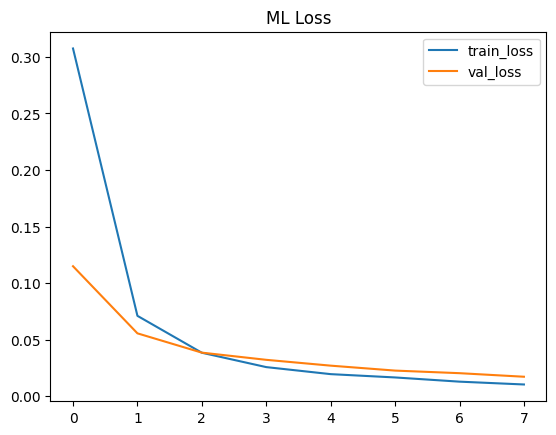

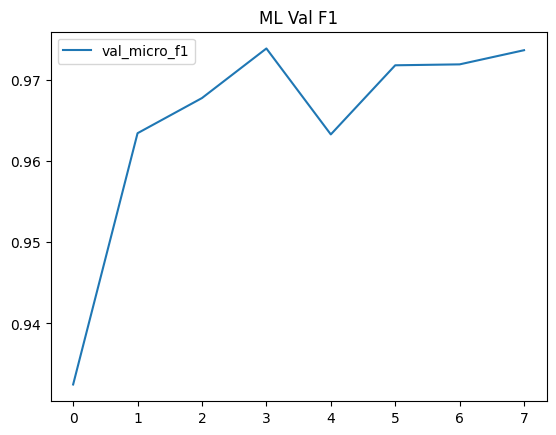

In [24]:
# --------------------------------------------------
# Célula 8 - Model multi-label (ResNet backbone, BCEWithLogitsLoss)
# --------------------------------------------------
model_ml = create_model(num_classes).to(DEVICE)  # same architecture but we'll use BCEWithLogits
# Replace final activation to output raw logits (already linear)
criterion_bce = nn.BCEWithLogitsLoss()
optimizer_ml = optim.Adam(model_ml.parameters(), lr=1e-4)

EPOCHS_ML = 8
best_val_f1 = 0.0
history_ml = {'train_loss':[], 'val_loss':[], 'val_f1':[]}

for epoch in range(EPOCHS_ML):
    model_ml.train()
    running_loss = 0.0
    total = 0
    for inputs, labels in tqdm(train_loader_ml, desc=f'Train ML epoch {epoch+1}/{EPOCHS_ML}'):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer_ml.zero_grad()
        outputs = model_ml(inputs)
        loss = criterion_bce(outputs, labels)
        loss.backward()
        optimizer_ml.step()
        running_loss += loss.item() * inputs.size(0)
        total += inputs.size(0)
    train_loss = running_loss / total

    # val metrics
    model_ml.eval()
    val_loss = 0.0
    all_targets = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader_ml:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model_ml(inputs)
            loss = criterion_bce(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_targets.append(labels.cpu().numpy())
            all_preds.append(probs)
    val_loss = val_loss / len(val_loader_ml.dataset)
    all_targets = np.vstack(all_targets)
    all_preds = np.vstack(all_preds)
    # threshold default 0.5
    pred_bin = (all_preds >= 0.5).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(all_targets, pred_bin, average='micro', zero_division=0)
    val_f1 = f1
    history_ml['train_loss'].append(train_loss)
    history_ml['val_loss'].append(val_loss)
    history_ml['val_f1'].append(val_f1)

    print(f'Epoch {epoch+1} train_loss {train_loss:.4f} val_loss {val_loss:.4f} val_micro_f1 {val_f1:.4f}')
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model_ml.state_dict(), OUTPUT_DIR/'best_ml.pth')

# Plots
plt.figure(); plt.plot(history_ml['train_loss'], label='train_loss'); plt.plot(history_ml['val_loss'], label='val_loss'); plt.legend(); plt.title('ML Loss'); plt.savefig(OUTPUT_DIR/'ml_loss.png')
plt.figure(); plt.plot(history_ml['val_f1'], label='val_micro_f1'); plt.legend(); plt.title('ML Val F1'); plt.savefig(OUTPUT_DIR/'ml_f1.png')

# --------------------------------------------------
# Célula 9 - Avaliação final no conjunto de teste (multi-label)
# --------------------------------------------------
model_ml.load_state_dict(torch.load(OUTPUT_DIR/'best_ml.pth', map_location=DEVICE))
model_ml.eval()
all_targets = []
all_probs = []
filenames_test = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader_ml, desc='Test ML'):
        inputs = inputs.to(DEVICE)
        outputs = model_ml(inputs)
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_probs.append(probs)
        all_targets.append(labels.numpy())

all_probs = np.vstack(all_probs)
all_targets = np.vstack(all_targets)

# Evaluate at threshold 0.5
preds_bin = (all_probs >= 0.5).astype(int)

micro_prec, micro_rec, micro_f1, _ = precision_recall_fscore_support(all_targets, preds_bin, average='micro', zero_division=0)
macro_prec, macro_rec, macro_f1, _ = precision_recall_fscore_support(all_targets, preds_bin, average='macro', zero_division=0)
ham_loss = hamming_loss(all_targets, preds_bin)

print('Multi-label test results (threshold=0.5):')
print('Micro P/R/F1:', micro_prec, micro_rec, micro_f1)
print('Macro P/R/F1:', macro_prec, macro_rec, macro_f1)
print('Hamming loss:', ham_loss)

# Per-class report
per_class = precision_recall_fscore_support(all_targets, preds_bin, average=None, zero_division=0)
per_class_df = pd.DataFrame({'class': class_names, 'precision': per_class[0], 'recall': per_class[1], 'f1': per_class[2]})
per_class_df.to_csv(OUTPUT_DIR/'per_class_ml.csv', index=False)
print('Per-class metrics saved to', OUTPUT_DIR/'per_class_ml.csv')

# Save confusion matrices per-class (multilabel confusion matrices)
ml_cm = multilabel_confusion_matrix(all_targets, preds_bin)
for i, cm in enumerate(ml_cm):
    np.savetxt(OUTPUT_DIR/f'cm_class_{class_names[i]}.csv', cm, delimiter=',', fmt='%d')

# Save test predictions with probs and binarized preds
filenames_test = test_df['filename'].values
preds_list = [class_names[i] for i in range(len(class_names))]

out_rows = []
for i, fname in enumerate(filenames_test):
    probs = all_probs[i]
    pred_labels = [class_names[j] for j in range(len(class_names)) if preds_bin[i, j] == 1]
    true_labels = [class_names[j] for j in range(len(class_names)) if all_targets[i, j] == 1]
    out_rows.append({'filename': fname, 'true': true_labels, 'pred': pred_labels, 'probs': probs.tolist()})

pd.DataFrame(out_rows).to_json(OUTPUT_DIR/'test_predictions.json', orient='records')
print('Saved test predictions to', OUTPUT_DIR/'test_predictions.json')

# --------------------------------------------------
# Célula 10 - Threshold tuning (opcional)
# --------------------------------------------------
# You can tune a per-class threshold to maximize F1 on validation set
val_probs = None
val_targets = None
with torch.no_grad():
    all_p = []
    all_t = []
    for inputs, labels in val_loader_ml:
        inputs = inputs.to(DEVICE)
        out = model_ml(inputs)
        all_p.append(torch.sigmoid(out).cpu().numpy())
        all_t.append(labels.numpy())
    val_probs = np.vstack(all_p)
    val_targets = np.vstack(all_t)

# simple per-class threshold search
best_thresholds = np.full(num_classes, 0.5)
for c in range(num_classes):
    best_f1 = 0.0
    best_t = 0.5
    for t in np.linspace(0.1,0.9,17):
        predc = (val_probs[:,c] >= t).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(val_targets[:,c], predc, average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds[c] = best_t

print('Best thresholds per class:', dict(zip(class_names, best_thresholds)))
np.savetxt(OUTPUT_DIR/'best_thresholds.txt', best_thresholds)

# Apply best thresholds to test
preds_best = (all_probs >= best_thresholds.reshape(1,-1)).astype(int)
prec_b, rec_b, f1_b, _ = precision_recall_fscore_support(all_targets, preds_best, average='micro', zero_division=0)
print('Test micro f1 with tuned thresholds:', f1_b)

# Save everything useful
torch.save({'single_model': OUTPUT_DIR/'best_single.pth', 'ml_model': OUTPUT_DIR/'best_ml.pth'}, OUTPUT_DIR/'models_info.pth')

print('Pipeline completo. Verifique pasta', OUTPUT_DIR, 'para arquivos gerados.')
